##What is Clip?
Clip contains two big models: a vision transformer for image embedding and a text transformer for text embedding. Clip has been trained on pairs of images and texts. The idea is to get embeding vector for a match image and text as close as possible to each other. So, Clip is able to take both images and text and embed them both into a similar vector space. In this notebook I want to show how we can use clip to search into unlabled and uncaptioned images only with text in a random image dataset. 

## Installing libraries

In [ ]:
! pip install torch transformers
# ! pip install git+https://github.com/openai/CLIP.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Importing Libraries

In [ ]:
import skimage
import os
# import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

##Loading the Dataset
I'm using a random dataset with 650 images with different subjects. it's part of this Kaggle dataset: https://www.kaggle.com/datasets/shamsaddin97/image-captioning-dataset-random-images

In [ ]:
original_images = []
images = []
texts = []
DATA_DIR = "/content/drive/MyDrive/random_dataset/images"


for filename in [filename for filename in os.listdir(DATA_DIR) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]

    image = Image.open(os.path.join(DATA_DIR, filename)).convert("RGB")

    original_images.append(image)
    images.append(image)

##Showing a few pics in the dataset

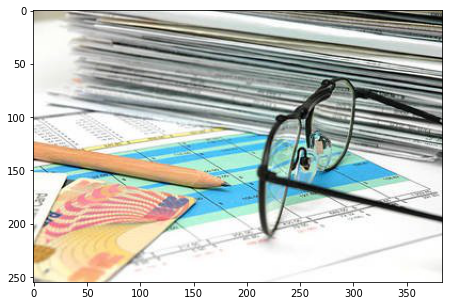

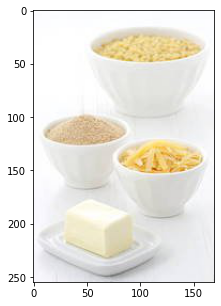

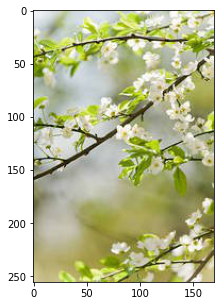

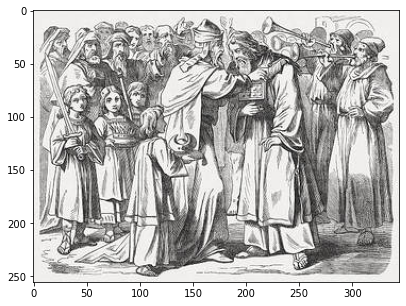

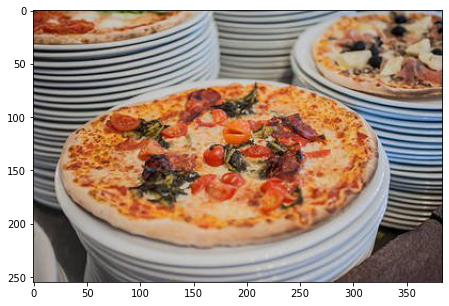

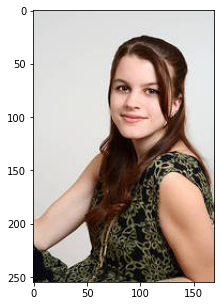

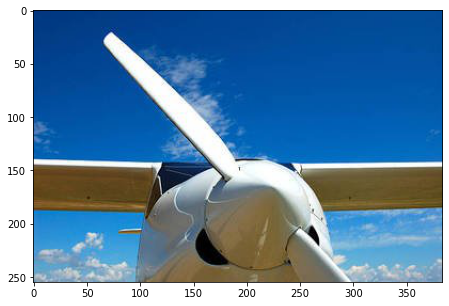

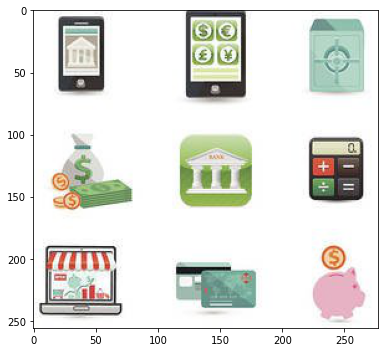

In [ ]:
sample_idx = np.random.randint(0, len(images)+1, 8).tolist()
sample_images = [images[i] for i in sample_idx]
len(sample_images)


for i in range(len(sample_images)):
  plt.figure(figsize=(16, 5))
  plt.imshow(sample_images[i])

plt.tight_layout()



In [ ]:
len(sample_images)


8

##Loading the model, processor the tokenizer

In [ ]:
#setting up GPU if is available:

device = "cuda" if torch.cuda.is_available() else \
          ("mps" if torch.backends.mps.is_available() else "cpu")
          
MODEL_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(MODEL_ID)
tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

##Getting image embeddings

In [ ]:
from tqdm import tqdm
import numpy as np

batch_size = 2
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
  batch = images[i:i + batch_size]

  batch = processor(
      text = None,
      images = batch,
      return_tensors = 'pt',
      padding = True
  )['pixel_values'].to(device)
  
  batch_emb = model.get_image_features(pixel_values=batch)
  batch_emb = batch_emb.squeeze(0)
  batch_emb = batch_emb.cpu().detach().numpy()

  if image_arr is None:
    image_arr = batch_emb
  else:
    image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape


image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)

100%|██████████| 328/328 [02:26<00:00,  2.24it/s]


##Getting text embeddings

In [ ]:
prompt = "happy girl" 

inputs = tokenizer(prompt, return_tensors="pt")
text_emb = model.get_text_features(**inputs)

text_emd = text_emb.cpu().detach().numpy()


##Finding closest matches

In [ ]:
with torch.no_grad():
  scores = np.dot(text_emb, image_arr) 

##Showing the results

2.5426095


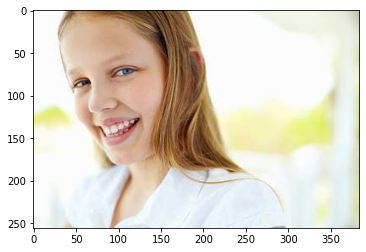

2.541552


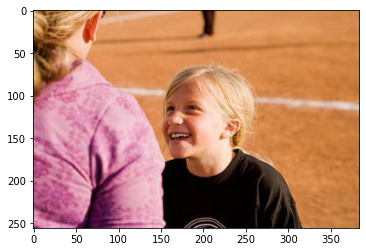

2.5117712


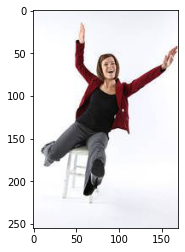

2.46177


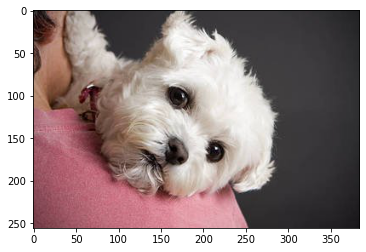

2.439085


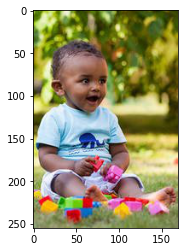

In [ ]:
top_k = 5
idx = np.argsort(-scores[0])[:top_k]

for i in idx:
  print(scores[0][i])
  plt.imshow(images[i])
  plt.show()

In [ ]:
prompt = "sad girl" 

inputs = tokenizer(prompt, return_tensors="pt")
text_emb = model.get_text_features(**inputs)

text_emd = text_emb.cpu().detach().numpy()


In [ ]:
with torch.no_grad():
  scores = np.dot(text_emb, image_arr) 

2.6621037


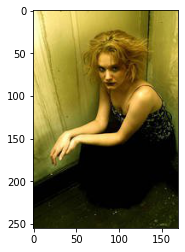

2.471106


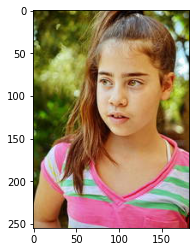

2.401046


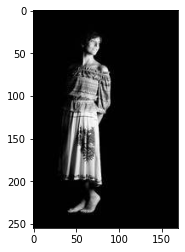

2.3197815


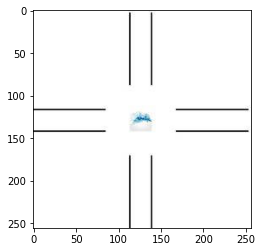

2.3160543


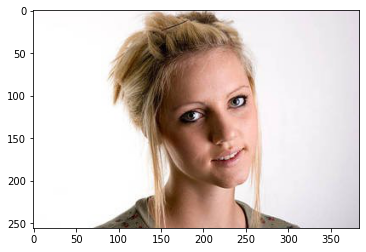

In [ ]:
top_k = 5
idx = np.argsort(-scores[0])[:top_k]

for i in idx:
  print(scores[0][i])
  plt.imshow(images[i])
  plt.show()